In [6]:
import os
import sys
home_dir = "../../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
from models.aa_common.performance_metrics import *

In [7]:
task = "pmd_analysis"
# ("dbnsfp", "sift"), ("dbnsfp", "polyphen2_HVAR"), ("dbnsfp", "cadd"), ("dbnsfp", "mvp"), ("dbnsfp", "metarnn"), ("dbnsfp", "revel"),
model_root_and_name_tuple_list = [("tape_rao", "unirep"), ("tape_rao", "protbert"), ("sequnet_dunham", "sequnet"), 
                                  ("esm_rives", "esm1b_t33_650M_UR50S"), ("esm_rives", "esm1v_t33_650M_UR90S"), ("esm_rives", "esm2_t33_650M_UR50D"),
                                  ("bioembeddings_dallago", "plus_rnn"), 
                                  ("bioembeddings_dallago", "prottrans_bert_bfd"), ("bioembeddings_dallago", "prottrans_albert_bfd"),
                                  ("bioembeddings_dallago", "prottrans_xlnet_uniref100"), 
                                  ("bioembeddings_dallago", "prottrans_t5_bfd"), ("bioembeddings_dallago", "prottrans_t5_uniref50"), ("bioembeddings_dallago", "prottrans_t5_xl_u50")]

# by default, we consider smaller means damaging (here Effect), but the following models have specific opposite meaning
models_larger_means_damaging = ["metarnn", "mvp", "polyphen2_HVAR", "cadd", "revel"]

metrics = ["AUC-ROC", "AUC-PR", "F1-max", "Th-max", "Precision", "Recall", "Accuracy", "Balanced-accuracy", "MCC"]

In [8]:
result_df = pd.read_csv(home_dir+f"models/aa_common/merged_predictions/{task}.csv", sep="\t")
result_df = result_df[(result_df["functional_effect"]=="Effect") | (result_df["functional_effect"]=="No effect")]
print(result_df.shape)
print(result_df.columns)

result_df.loc[result_df["functional_effect"]=="Effect", "class_numeric"] = 0
result_df.loc[result_df["functional_effect"]=="No effect", "class_numeric"] = 1

(25931, 28)
Index(['mut_id', 'pmd_id', 'protein', 'mut_PMD', 'mut_real', 'function',
       'taxid', 'function_e', 'function_e2', 'functional_effect', 'seq',
       'protein_id', 'wt', 'mut', 'prot_pos', 'unirep_pred', 'protbert_pred',
       'sequnet_pred', 'esm1b_t33_650M_UR50S_pred',
       'esm1v_t33_650M_UR90S_pred', 'esm2_t33_650M_UR50D_pred',
       'plus_rnn_pred', 'prottrans_bert_bfd_pred', 'prottrans_albert_bfd_pred',
       'prottrans_xlnet_uniref100_pred', 'prottrans_t5_bfd_pred',
       'prottrans_t5_uniref50_pred', 'prottrans_t5_xl_u50_pred'],
      dtype='object')


### Computing all methods performance metrics

In [9]:
output_file = home_dir+f"models/aa_common/performance_analysis/{task}.csv"

out = open(output_file, 'w')
out.write("Models\\Metrics")
for metric in metrics:
    out.write(f"\t{metric}")
out.write("\n")

for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
    print(model_name)
    model_pred_col = model_name + "_pred"
    result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]
    
    non_nan_result_df = result_df[~pd.isna(result_df[model_pred_col])]  # taking df for only non-NAN values
    
    if model_name in models_larger_means_damaging:
        non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
    
    auc_roc_score = get_auc_roc_score(non_nan_result_df)
    auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
    f1_max, th_max = get_f1max_and_th(precisions, recalls, thresholds)
    precision = get_precision_score(non_nan_result_df, th_max)
    recall = get_recall_score(non_nan_result_df, th_max)
    accuracy = get_accuracy_score(non_nan_result_df, th_max)
    balanced_accuracy = get_balanced_accuracy_score(non_nan_result_df, th_max)
    mcc = get_matthews_corrcoef(non_nan_result_df, th_max)
    
    permformance_scores = [auc_roc_score, auc_pr_score, f1_max, th_max, precision, recall, accuracy, balanced_accuracy, mcc]
    
    out.write(f"{model_name}")
    for score in permformance_scores:
        out.write(f"\t{score:.3f}")
    out.write("\n")
        
    
    # if i==5: break

out.close()

unirep
	AUC-ROC: 0.476
	AUC-PR: 0.493
	Best F1-Score: 0.678 at threshold: 0.076
	Precision score: 0.513 at threshold: 0.076
	Recall score: 1.000 at threshold: 0.076
	Accuracy score: 0.513 at threshold: 0.076
	Balanced accuracy score: 0.500 at threshold: 0.076
	MCC score: 0.014 at threshold: 0.076
protbert
	AUC-ROC: 0.542
	AUC-PR: 0.529
	Best F1-Score: 0.685 at threshold: 0.416
	Precision score: 0.526 at threshold: 0.416
	Recall score: 0.981 at threshold: 0.416
	Accuracy score: 0.537 at threshold: 0.416
	Balanced accuracy score: 0.525 at threshold: 0.416
	MCC score: 0.124 at threshold: 0.416
sequnet
	AUC-ROC: 0.338
	AUC-PR: 0.408
	Best F1-Score: 0.678 at threshold: 0.000
	Precision score: 0.513 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.513 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.009 at threshold: 0.000
esm1b_t33_650M_UR50S
	AUC-ROC: 0.736
	AUC-PR: 0.700
	Best F1-Score: 0.729 at threshold: 0.290
	Precisio

### Computing random classifiers average performance metrics of 10 runs

In [10]:
import random

model_name = "random_classifier"
auc_roc_score_list, auc_pr_score_list, f1_max_list, th_max_list, precision_list, recall_list, accuracy_list, balanced_accuracy_list, mcc_list = [], [], [], [], [], [], [], [], []

for i in range(10):
    result_df["preds"] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
    non_nan_result_df = result_df
        
    auc_roc_score = get_auc_roc_score(non_nan_result_df)
    auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
    f1_max, th_max = get_f1max_and_th(precisions, recalls, thresholds)
    precision = get_precision_score(non_nan_result_df, th_max)
    recall = get_recall_score(non_nan_result_df, th_max)
    accuracy = get_accuracy_score(non_nan_result_df, th_max)
    balanced_accuracy = get_balanced_accuracy_score(non_nan_result_df, th_max)
    mcc = get_matthews_corrcoef(non_nan_result_df, th_max)

    auc_roc_score_list.append(auc_roc_score)
    auc_pr_score_list.append(auc_pr_score)
    f1_max_list.append(f1_max)
    th_max_list.append(th_max)
    precision_list.append(precision)
    recall_list.append(recall)
    accuracy_list.append(accuracy)
    balanced_accuracy_list.append(balanced_accuracy)
    mcc_list.append(mcc)
    

permformance_scores = [np.mean(auc_roc_score_list), np.mean(auc_pr_score_list), np.mean(f1_max_list), 
                       np.mean(th_max_list), np.mean(precision_list), np.mean(recall_list), 
                       np.mean(accuracy_list), np.mean(balanced_accuracy_list), np.mean(mcc_list)]
    
output_file = home_dir+f"models/aa_common/performance_analysis/{task}.csv"
out = open(output_file, 'a')

out.write(f"{model_name}")
for score in permformance_scores:
    out.write(f"\t{score:.3f}")
out.write("\n")
out.close()

	AUC-ROC: 0.490
	AUC-PR: 0.504
	Best F1-Score: 0.678 at threshold: 0.000
	Precision score: 0.513 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.513 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000
	AUC-ROC: 0.490
	AUC-PR: 0.504
	Best F1-Score: 0.678 at threshold: 0.000
	Precision score: 0.513 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.513 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000
	AUC-ROC: 0.490
	AUC-PR: 0.504
	Best F1-Score: 0.678 at threshold: 0.000
	Precision score: 0.513 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.513 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000
	AUC-ROC: 0.490
	AUC-PR: 0.504
	Best F1-Score: 0.678 at threshold: 0.000
	Precision score: 0.513 at threshold: 0.000
	Recall sc

	AUC-PR: 0.697
	Best F1-Score: 0.740 at threshold: 0.368


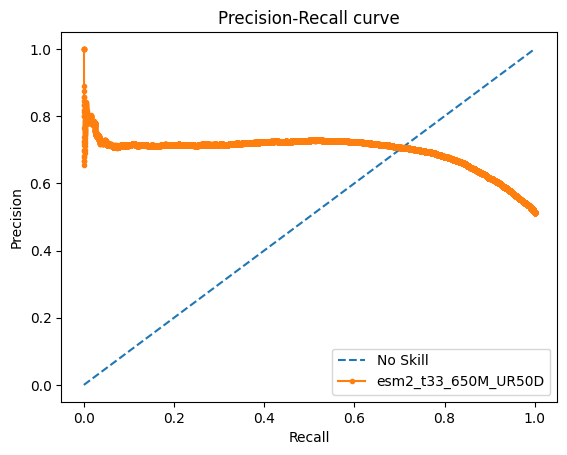

In [11]:
model_name = "esm2_t33_650M_UR50D"
model_pred_col = model_name + "_pred"
result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]

non_nan_result_df = result_df[~pd.isna(result_df[model_pred_col])]  # taking df for only non-NAN values

if model_name in models_larger_means_damaging:
        non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)

auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
f1_max, th_max = get_f1max_and_th(precisions, recalls, thresholds)

import matplotlib.pyplot as plt
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(recalls, precisions, marker='.', label=f'{model_name}')
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()
plt.title("Precision-Recall curve")
plt.show()